Toutes les transactions blockchain répertoriés : https://etherscan.io/

In [ ]:
import os
import shutil
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Dossiers
download_dir = os.getcwd()
data_dir = os.path.join(download_dir, "data_etherscan")
os.makedirs(data_dir, exist_ok=True)

# Config Edge (téléchargement auto)
options = Options()
options.use_chromium = True
prefs = {
    "download.default_directory": download_dir,
    "download.prompt_for_download": False,
    "download.directory_upgrade": True
}
options.add_experimental_option("prefs", prefs)

driver = webdriver.Edge(options=options)

# Paramètres
base_url = "https://etherscan.io/txs?ps=100&p="
max_pages = 3
csv_files = []

timestamp = time.strftime("%Y%m%d_%H%M%S")

# Scraping et téléchargement
for page in range(1, max_pages + 1):
    print(f"\n📄 Page {page}")
    url = base_url + str(page)
    driver.get(url)

    try:
        WebDriverWait(driver, 15).until(
            EC.element_to_be_clickable((By.ID, "btnExportQuickTransactionListCSV"))
        ).click()

        print("📥 Téléchargement du CSV lancé...")
        time.sleep(5)  # attendre que le fichier soit téléchargé

        # Récupère le dernier fichier .csv
        downloaded_files = sorted(
            [f for f in os.listdir(download_dir) if f.endswith(".csv")],
            key=lambda x: os.path.getctime(os.path.join(download_dir, x)),
            reverse=True
        )

        if downloaded_files:
            latest_file = downloaded_files[0]
            src_path = os.path.join(download_dir, latest_file)
            dst_path = os.path.join(data_dir, f"page_{page}_{timestamp}.csv")

            shutil.move(src_path, dst_path)
            print(f"✅ Fichier déplacé vers {dst_path}")
            csv_files.append(dst_path)

    except Exception as e:
        print(f"❌ Erreur sur la page {page} : {e}")

driver.quit()


📄 Page 1
📥 Téléchargement du CSV lancé...
✅ Fichier déplacé vers h:\Desktop\EtherScam\data_etherscan\page_1_20250404_203249.csv

📄 Page 2
📥 Téléchargement du CSV lancé...
✅ Fichier déplacé vers h:\Desktop\EtherScam\data_etherscan\page_2_20250404_203249.csv

📄 Page 3
📥 Téléchargement du CSV lancé...
✅ Fichier déplacé vers h:\Desktop\EtherScam\data_etherscan\page_3_20250404_203249.csv


In [ ]:
# Fusion de tous les fichiers CSV du dossier data/
print("\n📊 Fusion de tous les CSV présents dans le dossier /data")
all_csvs = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")]

df_eth_list = []
for f in all_csvs:
    try:
        df_eth = pd.read_csv(f)
        df_eth_list.append(df_eth)
    except Exception as e:
        print(f"⚠️ Erreur lecture fichier {f} : {e}")

if df_eth_list:
    df_eth_final = pd.concat(df_eth_list, ignore_index=True)

    # Supprimer les doublons par Txn Hash
    if 'Txn Hash' in df_eth_final.columns:
        before = len(df_eth_final)
        df_eth_final.drop_duplicates(subset='Txn Hash', inplace=True)
        after = len(df_eth_final)
        print(f"🧹 {before - after} doublon(s) supprimé(s) sur {before} lignes.")

    # Créer dossier exports/
    export_dir = os.path.join(download_dir, "mongo_etherscan")
    os.makedirs(export_dir, exist_ok=True)

    # Sauvegarder avec timestamp
    output_filename = f"etherscan_transactions_full_{timestamp}.csv"
    output_path = os.path.join(export_dir, output_filename)
    df_eth_final.to_csv(output_path, index=False)

    print(f"\n✅ Fichier final enregistré dans : {output_path}")
    print(f"{len(all_csvs)} fichiers fusionnés depuis /data/")
    print(f"Total de transactions uniques : {len(df_eth_final)}")
    print("\nAperçu des 5 premières lignes :\n")
    print(df_eth_final.head())
else:
    print("⚠️ Aucun fichier CSV valide à fusionner.")


📊 Fusion de tous les CSV présents dans le dossier /data

✅ Fichier final enregistré dans : h:\Desktop\EtherScam\mango_etherscan\etherscan_transactions_full_20250404_203249.csv
📦 9 fichiers fusionnés depuis /data/
📊 Total de transactions uniques : 900

🔍 Aperçu des 5 premières lignes :

                                    Transaction Hash  \
0  0xf4479eea546a6fa3cc8d67043bb148790052237b3393...   
1  0x6c6deabf36024a0aa9866b8a1979b57b173b88d609ef...   
2  0x0dd81b1e6237c4aee664b6b0c4eebdc9650283ee4e54...   
3  0xda9c7be7452f78d90c405e5e6ffffb6e788fc604670b...   
4  0xc672cbad3246cb0e232dcd64f1bc2bae0537801bc2b2...   

                                   Status         Method   Blockno  \
0                                 Success       Transfer  22180105   
1                                 Success       Transfer  22180105   
2                                 Success       Transfer  22180105   
3          Error in Main Txn : out of gas  Transfer From  22180105   
4  Error in Main Txn : ex

Croisement potentiel : https://cryptoscamdb.org/scams

## 🔍 Analyse d’une adresse suspecte sur Ethereum

Nous avons analysé l’adresse suivante :  
`0xD0cC2B24980CBCCA47EF755Da88B220a82291407`

Cette adresse est **répertoriée dans la base CryptoScamDB**, une base de données open source recensant les sites et adresses associés à des arnaques crypto. Elle est notamment liée à un site frauduleux imitant **MyEtherWallet**, visant à dérober les clés privées des utilisateurs.

### 🧠 Indicateurs comportementaux d’un scam

#### 1. Présence dans `from` et `to`
L’adresse apparaît :
- en tant que **destinataire** (`to`) dans plusieurs transactions, suggérant la **réception de fonds de victimes** ;
- puis en tant qu’**expéditeur** (`from`) dans la majorité des transactions, ce qui laisse penser à une **redistribution rapide** vers d'autres adresses.

#### 2. Répartition rapide des fonds
Sur 87 transactions valides :
- **21** sont des réceptions (ETH envoyés vers l’adresse par d’autres wallets) ;
- **66** sont des envois (ETH transférés vers de nouvelles adresses, souvent inconnues ou peu actives) ;
- Un seul destinataire a reçu **plus de 364 ETH**, ce qui suggère un **cash-out massif**.

#### 3. Aucun comportement utilisateur normal
- Pas d’interaction avec des contrats intelligents ;
- Pas de tokens ERC20 ;
- Aucune activité de type achat, vente, staking, ou DeFi ;
- L’unique activité de ce wallet est de **recevoir puis vider**.

### 📈 Données chiffrées
| Type                   | Montant ETH |
|------------------------|-------------|
| Total reçu (to)        | 367.21      |
| Total envoyé (from)    | 366.92      |
| Adresses "from" uniques | 18         |
| Adresses "to" uniques   | 48         |

### ✅ Conclusion
Le comportement de cette adresse suit le schéma typique d’un scam :
- réception groupée de fonds probablement volés (phishing) ;
- redistribution immédiate vers des adresses secondaires ;
- aucune autre interaction légitime ;
- référencée officiellement dans une **base de données anti-scam reconnue**.

Il s’agit très probablement d’un **hub central de scam** ou d’un **wallet de cash-out** utilisé pour blanchir ou transférer rapidement des fonds issus d’activités malveillantes.


📅 Date de la première transaction : 26 juillet 2017 à 13h41

📅 Date de la dernière transaction : 9 septembre 2017 à 14h35

⏳ Durée totale d’activité : 45 jours

Jeu de donnée d'apprentissage à ajouter dans MangoDB : https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset

In [ ]:
import kagglehub
import os
import shutil
import pandas as pd
from pymongo import MongoClient

# Télécharger depuis kagglehub
path_cache = kagglehub.dataset_download("vagifa/ethereum-frauddetection-dataset")

# Créer le dossier local
project_data_path = os.path.join(os.getcwd(), "data_kaggle")
os.makedirs(project_data_path, exist_ok=True)

# Chercher le CSV et le copier dans le dossier
csv_file = None
for file in os.listdir(path_cache):
    if file.endswith(".csv"):
        src = os.path.join(path_cache, file)
        dst = os.path.join(project_data_path, file)
        shutil.copy(src, dst)
        csv_file = dst
        print(f"✅ Fichier copié dans : {csv_file}")
        break

# Lire le fichier CSV
if csv_file:
    df = pd.read_csv(csv_file)
    print(f"📄 Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes")
else:
    raise FileNotFoundError("❌ Aucun fichier CSV trouvé.")

#####################################################################################################################
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017")  # ou lien MongoDB Atlas
db = client["fraud_detection"]
collection = db["transactions"]

# 6. Nettoyage (optionnel)
collection.drop()  # Pour ne pas dupliquer

# 7. Insertion dans MongoDB
collection.insert_many(df.to_dict(orient="records"))
print("📦 Données insérées dans MongoDB !")

# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017")  # ou MongoDB Atlas si besoin
db = client["fraud_detection"]
collection = db["transactions"]

# Charger les données de MongoDB vers un DataFrame
df_eth = pd.DataFrame(list(collection.find()))

# Optionnel : supprimer la colonne '_id' ajoutée automatiquement par MongoDB
if "_id" in df_eth.columns:
    df_eth.drop(columns=["_id"], inplace=True)

# Aperçu
print("\n🔍 Aperçu du dataset :")
print(df_eth.head())

print("\n📊 Infos sur le dataset :")
print(f"Nombre de lignes : {len(df_eth)}")
print(f"Nombre de colonnes : {len(df_eth.columns)}")
print(f"Nom des colonnes : {list(df_eth.columns)}")



✅ Fichier copié dans : h:\Desktop\EtherScam\data_kaggle\transaction_dataset.csv
📄 Données chargées : 9841 lignes, 51 colonnes
📦 Données insérées dans MongoDB !

🔍 Aperçu du dataset :
   Unnamed: 0  Index                                     Address  FLAG  \
0           0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8     0   
1           1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed     0   
2           2      3  0x0002bda54cb772d040f779e88eb453cac0daa244     0   
3           3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e     0   
4           4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89     0   

   Avg min between sent tnx  Avg min between received tnx  \
0                    844.26                       1093.71   
1                  12709.07                       2958.44   
2                 246194.54                       2434.02   
3                  10219.60                      15785.09   
4                     36.61                      10707.77   

   Ti

# 📚 Dictionnaire des colonnes – Dataset Ethereum Fraud Detection

## 🧾 Identifiants

| Colonne        | Signification                                                |
|----------------|--------------------------------------------------------------|
| `Unnamed: 0`   | Index automatique ajouté lors de la sauvegarde CSV           |
| `Index`        | Numéro d’observation                                         |
| `Address`      | Adresse Ethereum analysée                                    |
| `FLAG`         | 🚨 Étiquette binaire : **0 = normal**, **1 = fraudeur**       |

---

## 📊 Statistiques temporelles

| Colonne                                | Description                                               |
|----------------------------------------|-----------------------------------------------------------|
| `Avg min between sent tnx`             | Temps moyen (en minutes) entre chaque transaction envoyée |
| `Avg min between received tnx`         | Temps moyen entre chaque transaction reçue                |
| `Time Diff between first and last (Mins)` | Durée d'activité totale (en minutes)                    |

---

## 📦 Statistiques sur le volume

| Colonne                             | Description                                                   |
|-------------------------------------|---------------------------------------------------------------|
| `Sent tnx`                          | Nombre total de transactions envoyées                         |
| `Received Tnx`                      | Nombre total de transactions reçues                           |
| `Number of Created Contracts`       | Nombre de contrats déployés                                   |
| `Unique Received From Addresses`    | Nb d’adresses uniques ayant envoyé des fonds                  |
| `Unique Sent To Addresses`          | Nb d’adresses uniques ayant reçu des fonds                    |

---

## 💸 Valeurs ETH

| Colonne                             | Description                                             |
|-------------------------------------|---------------------------------------------------------|
| `min value received`                | Valeur minimale reçue en ETH                            |
| `max value received`                | Valeur maximale reçue                                   |
| `avg val received`                  | Valeur moyenne reçue                                    |
| `min val sent`                      | Valeur minimale envoyée                                 |
| `max val sent`                      | Valeur maximale envoyée                                 |
| `avg val sent`                      | Valeur moyenne envoyée                                  |
| `min value sent to contract`        | Min envoyé vers un contrat                              |
| `max val sent to contract`          | Max envoyé vers un contrat                              |
| `avg value sent to contract`        | Moyenne envoyée vers un contrat                         |

---

## 🔁 Volume total

| Colonne                                            | Description                                  |
|----------------------------------------------------|----------------------------------------------|
| `total transactions (including tnx to create contract)` | Total des transactions effectuées      |
| `total Ether sent`                                 | Total d’ETH envoyés                          |
| `total ether received`                             | Total d’ETH reçus                            |
| `total ether sent contracts`                       | Total d’ETH envoyés vers des contrats        |
| `total ether balance`                              | Solde final de l’adresse                     |

---

## 🪙 Données ERC20

| Colonne                            | Description                                                  |
|------------------------------------|--------------------------------------------------------------|
| `Total ERC20 tnxs`                | Nombre total de transactions ERC20                          |
| `ERC20 total Ether received`      | Montant total reçu via tokens ERC20                         |
| `ERC20 total ether sent`          | Montant total envoyé via tokens ERC20                       |
| `ERC20 total Ether sent contract` | Montant total ERC20 vers des contrats                       |
| `ERC20 uniq sent addr`            | Nombre d’adresses uniques de destination                    |
| `ERC20 uniq rec addr`             | Nombre d’adresses uniques d’origine                         |
| `ERC20 uniq sent addr.1`          | Variante (possiblement un doublon à vérifier)               |
| `ERC20 uniq rec contract addr`    | Nb de contrats différents ayant reçu des tokens             |

---

## ⏱️ Timings ERC20

| Colonne                                   | Description                                          |
|-------------------------------------------|------------------------------------------------------|
| `ERC20 avg time between sent tnx`         | Temps moyen entre envois de tokens ERC20            |
| `ERC20 avg time between rec tnx`          | Temps moyen entre réceptions de tokens ERC20        |
| `ERC20 avg time between rec 2 tnx`        | Autre mesure de réception ERC20                     |
| `ERC20 avg time between contract tnx`     | Temps moyen entre interactions ERC20 avec contrat   |

---

## 📊 Valeurs ERC20

| Colonne                                | Description                                             |
|----------------------------------------|---------------------------------------------------------|
| `ERC20 min val rec`                    | Montant minimal reçu en token                          |
| `ERC20 max val rec`                    | Montant maximal reçu                                   |
| `ERC20 avg val rec`                    | Montant moyen reçu                                     |
| `ERC20 min val sent`                   | Montant minimal envoyé                                 |
| `ERC20 max val sent`                   | Montant maximal envoyé                                 |
| `ERC20 avg val sent`                   | Montant moyen envoyé                                   |
| `ERC20 min val sent contract`          | Montant minimal vers un contrat ERC20                  |
| `ERC20 max val sent contract`          | Montant maximal vers un contrat                        |
| `ERC20 avg val sent contract`          | Montant moyen vers un contrat                          |

---

## 🧬 Typologie des tokens

| Colonne                          | Description                                        |
|----------------------------------|----------------------------------------------------|
| `ERC20 uniq sent token name`     | Nom(s) des tokens ERC20 envoyés                   |
| `ERC20 uniq rec token name`      | Nom(s) des tokens ERC20 reçus                     |
| `ERC20 most sent token type`     | Token ERC20 le plus souvent envoyé (type ou nom)  |
| `ERC20_most_rec_token_type`      | Token ERC20 le plus souvent reçu                  |

---

## ✅ À retenir pour détecter les scams

- Les adresses **frauduleuses (`FLAG = 1`)** montrent souvent :
  - Un grand nombre de **transactions envoyées** (`Sent tnx`)
  - Très **peu de réception** (`Received Tnx`)
  - Beaucoup d’interactions avec des **contrats**
  - Une **activité concentrée dans le temps**
  - Des tokens **peu communs** ou très variés

---



On supprime ce que l'on ne peut pas retrouver sur ethersacn

In [4]:
cols_to_delete = [
    'Unnamed: 0',  # Index automatique inutile (généré lors de l'enregistrement du CSV)
    'Index',  # Doublon d'index, sans intérêt analytique

    'Number of Created Contracts',  # Nombre de smart contracts créés, difficile à extraire via l'API txlist sans analyse poussée

    # Valeurs liées aux envois vers des smart contracts (non fournis directement par l’API txlist)
    'min value sent to contract',  # Minimum envoyé vers un contrat
    'max val sent to contract',    # Maximum envoyé vers un contrat
    'avg value sent to contract',  # Moyenne envoyée vers des contrats

    # Transactions de tokens ERC20 – non visibles dans l’API txlist classique (module séparé requis)
    ' Total ERC20 tnxs',                     # Nombre total de transactions ERC20
    ' ERC20 total Ether received',           # Total d’ether reçu via des tokens
    ' ERC20 total ether sent',               # Total envoyé
    ' ERC20 total Ether sent contract',      # Envoyé vers des contrats via tokens

    # Adresses uniques pour tokens ERC20 – nécessite module ERC20 spécifique
    ' ERC20 uniq sent addr',                 # Nombre d’adresses uniques d’envoi de tokens
    ' ERC20 uniq rec addr',                  # Nombre d’adresses uniques de réception
    ' ERC20 uniq sent addr.1',               # Doublon possible
    ' ERC20 uniq rec contract addr',         # Nombre de contrats ERC20 différents

    # Temps entre transactions ERC20 – nécessite une analyse chronologique avancée
    ' ERC20 avg time between sent tnx',
    ' ERC20 avg time between rec tnx',
    ' ERC20 avg time between rec 2 tnx',
    ' ERC20 avg time between contract tnx',

    # ❌ Colonne supprimée volontairement car difficile à calculer et non utilisée ici
    'total ether sent contracts',

    # Valeurs associées aux transferts ERC20
    ' ERC20 min val rec',                    # Minimum reçu en tokens
    ' ERC20 max val rec',                    # Maximum reçu
    ' ERC20 avg val rec',                    # Moyenne reçue
    ' ERC20 min val sent',                   # Minimum envoyé
    ' ERC20 max val sent',                   # Maximum envoyé
    ' ERC20 avg val sent',                   # Moyenne envoyée
    ' ERC20 min val sent contract',          # Minimum envoyé vers un contrat
    ' ERC20 max val sent contract',          # Maximum envoyé vers un contrat
    ' ERC20 avg val sent contract',          # Moyenne envoyée vers un contrat

    # Infos sur les tokens ERC20 manipulés – pas accessibles directement dans l’API txlist
    ' ERC20 uniq sent token name',
    ' ERC20 uniq rec token name',
    ' ERC20 most sent token type',
    ' ERC20_most_rec_token_type'
]

# Suppression des colonnes du DataFrame
df_eth = df_eth.drop(columns=cols_to_delete)

In [ ]:
print("\n📊 Infos sur le dataset :")
print(f"Nombre de lignes : {len(df_eth)}")
print(f"Nombre de colonnes : {len(df_eth.columns)}")
print(f"Nom des colonnes : {list(df_eth.columns)}")


# 📤 Exporter sans la colonne FLAG si elle existe
df_export = df_eth.drop(columns=["FLAG"], errors="ignore")

df_export.to_csv("wallets_test.csv", index=False, encoding="utf-8")
print("\n✅ Fichier 'wallets_test.csv' exporté sans la colonne FLAG.")


📊 Infos sur le dataset :
🔢 Nombre de lignes : 9841
🧱 Nombre de colonnes : 19
📋 Nom des colonnes : ['Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether balance']

✅ Fichier 'wallets_test.csv' exporté sans la colonne FLAG.


Ici on va nettoyer et unfiformer les données puis faire le modèle XGBoost, souvent très efficace pour la classification :
--

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ===================== Nettoyage =====================
print("\n📊 Infos initiales sur le dataset :")
print(f"Lignes : {len(df_eth)}, Colonnes : {len(df_eth.columns)}")
print(f"Colonnes : {list(df_eth.columns)}")

# Nettoyage noms de colonnes
df_eth.columns = df_eth.columns.str.strip()

# Suppression de la colonne 'Address'
if 'Address' in df_eth.columns:
    df_eth = df_eth.drop(columns=['Address'])

# Conversion en numérique
for col in df_eth.columns:
    df_eth[col] = pd.to_numeric(df_eth[col], errors='coerce')

# Suppression des doublons
nb_doublons = df_eth.duplicated().sum()
df_eth = df_eth.drop_duplicates()
print(f"🔁 Doublons supprimés : {nb_doublons}")

# Suppression des NaN
nb_avant = len(df_eth)
df_eth = df_eth.dropna()
nb_apres = len(df_eth)
print(f"✅ Lignes conservées : {nb_apres} / {nb_avant} (supprimées : {nb_avant - nb_apres})")

# ===================== Séparation X / y =====================
y = df_eth['FLAG'].astype(int)
X = df_eth.drop(columns=['FLAG'])

# ===================== 🔀 Split train / test =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


📊 Infos initiales sur le dataset :
🔢 Lignes : 9841, 🧱 Colonnes : 19
📋 Colonnes : ['Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether balance']
🔁 Doublons supprimés : 573
✅ Lignes conservées : 9268 / 9268 (supprimées : 0)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

from tqdm import tqdm
from itertools import product
import warnings
import logging

# Suppress warnings
logging.getLogger("xgboost").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

# ===================== Hyperparameter Grid =====================
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample'],
    param_grid['colsample_bytree']
))

# ===================== Train/test split (define X and y before this) =====================
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ===================== Manual GridSearch =====================
print("\nManual GridSearch using tqdm...\n")
best_acc = 0
best_model = None
best_params = {}
results = []

for n_est, max_d, lr, subs, col in tqdm(param_combinations, desc="GridSearch XGBoost"):
    model = XGBClassifier(
        n_estimators=n_est,
        max_depth=max_d,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=col,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    results.append({
        'params': {
            'n_estimators': n_est,
            'max_depth': max_d,
            'learning_rate': lr,
            'subsample': subs,
            'colsample_bytree': col
        },
        'accuracy': acc,
        'model': model
    })

    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_params = results[-1]['params']


Manual GridSearch using tqdm...



GridSearch XGBoost: 100%|██████████| 243/243 [02:04<00:00,  1.96it/s]



Top 3 parameter combinations:
1. Accuracy: 0.9563 - Params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}
2. Accuracy: 0.9558 - Params: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8}
3. Accuracy: 0.9552 - Params: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}

Best Parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}
Best Accuracy: 95.63%


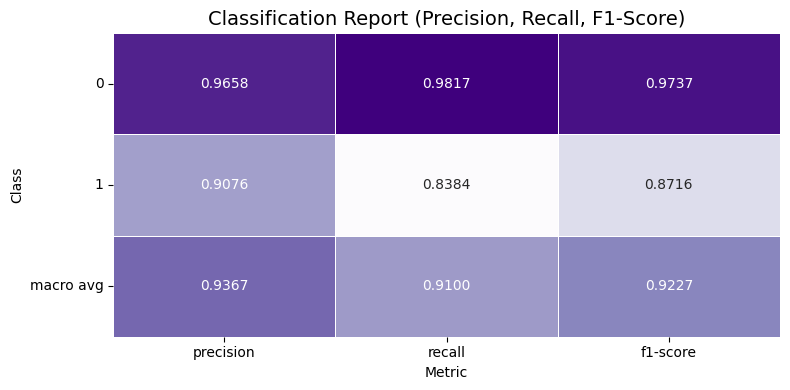

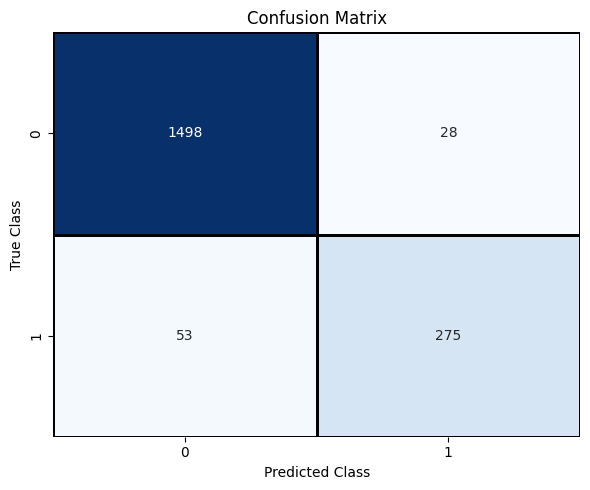

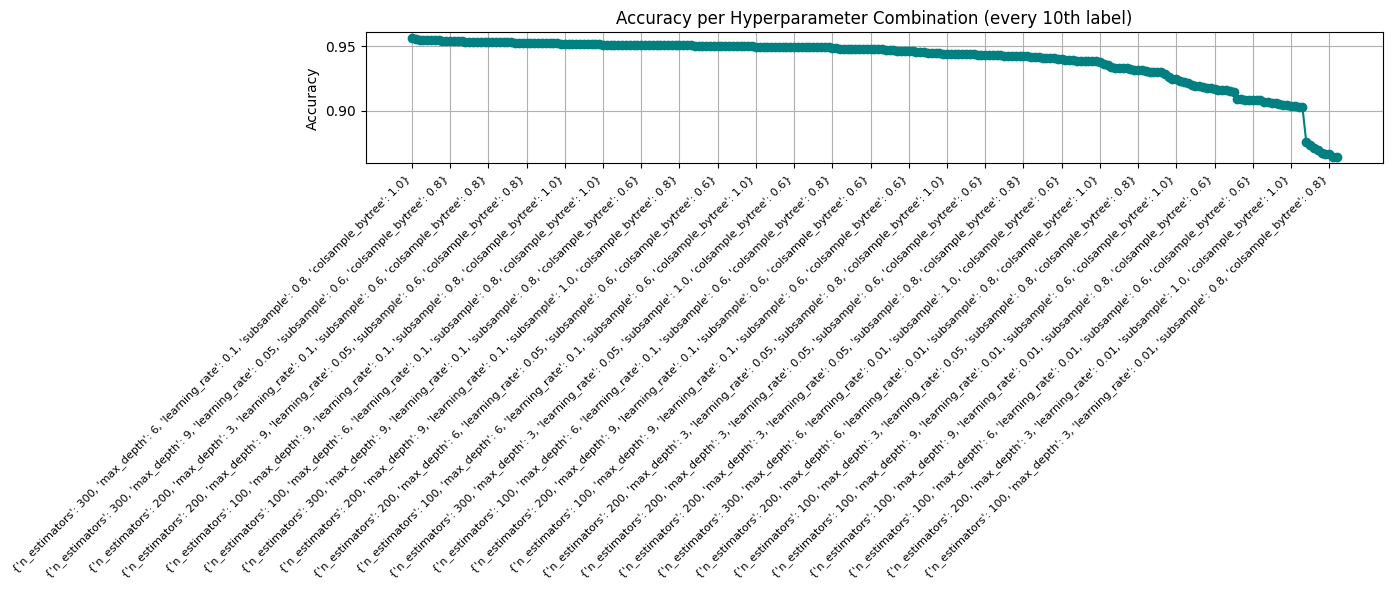

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_13960\651755006.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances, y=feat_importances.index, palette="viridis")


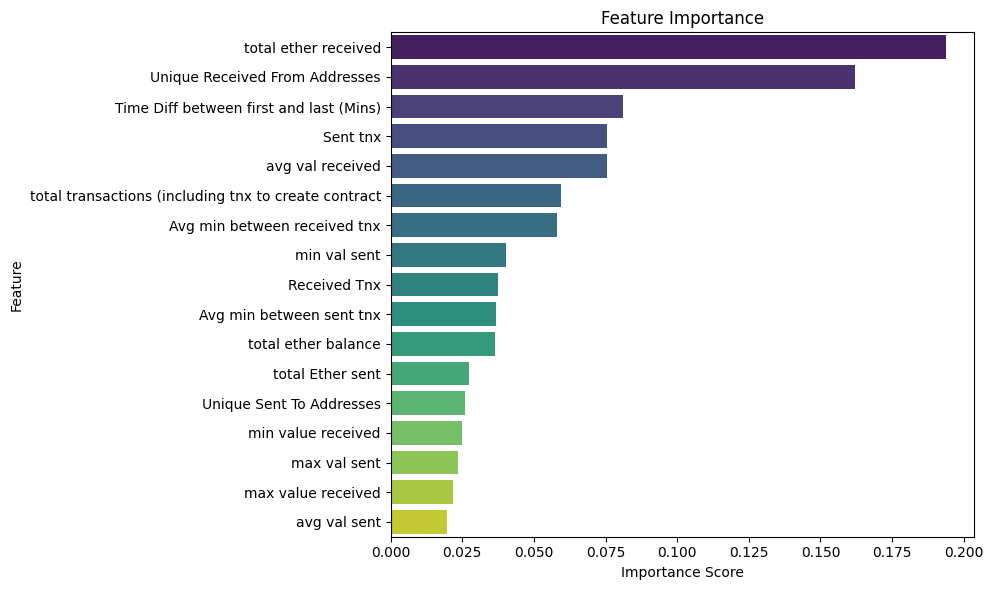

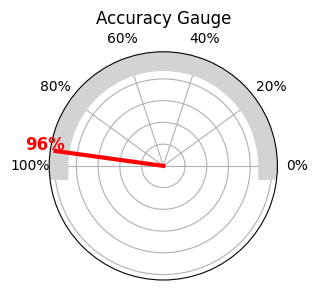

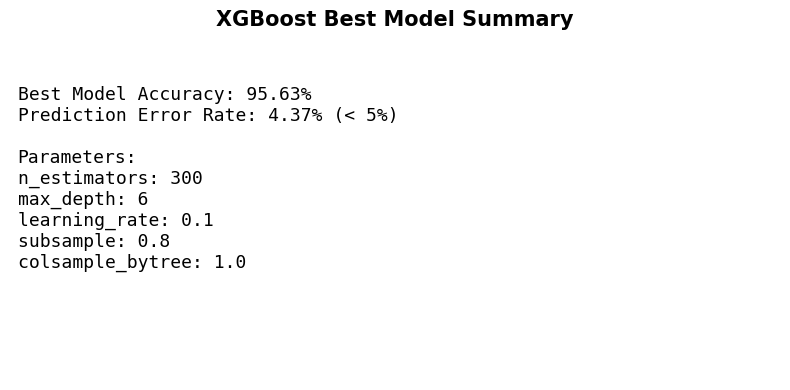

Colonnes des features :
['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether balance']


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create output folder
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

# ===================== Display Top Results =====================
results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)

print("\nTop 3 parameter combinations:")
for i, res in enumerate(results_sorted[:3]):
    print(f"{i+1}. Accuracy: {res['accuracy']:.4f} - Params: {res['params']}")

print(f"\nBest Parameters: {best_params}")
print(f"Best Accuracy: {best_acc * 100:.2f}%")

# ===================== Evaluation =====================
model = best_model
y_pred = model.predict(X_test)

# ===================== Classification Report (Heatmap) =====================
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df = report_df.drop(index='accuracy', errors='ignore')
metrics_to_plot = ['precision', 'recall', 'f1-score']
report_plot = report_df[metrics_to_plot].iloc[:3]  # classes + macro avg

plt.figure(figsize=(8, 4))
sns.heatmap(report_plot, annot=True, fmt=".4f", cmap="Purples", cbar=False, linewidths=0.5)
plt.title("Classification Report (Precision, Recall, F1-Score)", fontsize=14)
plt.xlabel("Metric")
plt.ylabel("Class")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{output_dir}/classification_report_heatmap.png")
plt.show()

# ===================== Confusion Matrix =====================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=1, linecolor='black')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png")
plt.show()

# ===================== Accuracy by Hyperparameter Combination =====================
label_list = [str(res['params']) for res in results_sorted]
accuracy_list = [res['accuracy'] for res in results_sorted]
indices = list(range(len(label_list)))
visible_ticks = [i for i in indices if i % 10 == 0]
visible_labels = [label_list[i] for i in visible_ticks]

plt.figure(figsize=(14, 6))
plt.plot(indices, accuracy_list, marker='o', color='teal')
plt.xticks(ticks=visible_ticks, labels=visible_labels, rotation=45, ha='right', fontsize=8)
plt.ylabel("Accuracy")
plt.title("Accuracy per Hyperparameter Combination (every 10th label)")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/accuracy_hyperparameters.png")
plt.show()

# ===================== Feature Importance =====================
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(f"{output_dir}/feature_importance.png")
plt.show()

# ===================== Accuracy Gauge (Polar Plot) =====================
accuracy = accuracy_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw={'projection': 'polar'})
theta = np.linspace(0, np.pi, 100)
r = np.ones_like(theta)
ax.plot(theta, r, color='lightgrey', linewidth=20)
acc_angle = accuracy * np.pi
ax.plot([acc_angle, acc_angle], [0, 1], color='red', linewidth=3)
ax.text(acc_angle, 1.1, f"{np.ceil(accuracy * 100):.0f}%", color='red', fontsize=12, fontweight='bold', ha='center')
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, np.pi, 6))
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_title("Accuracy Gauge", pad=20)
ax.set_facecolor('white')
plt.tight_layout()
plt.savefig(f"{output_dir}/accuracy_gauge.png")
plt.show()

# ===================== Text Summary of Best Model =====================
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis("off")
best_accuracy = best_acc
error_rate = 1 - best_accuracy
main_text = f"Best Model Accuracy: {best_accuracy*100:.2f}%"
error_text = f"Prediction Error Rate: {error_rate*100:.2f}% (< 5%)"
params_text = f"Parameters:\n" + "\n".join([f"{k}: {v}" for k, v in best_params.items()])
full_text = f"{main_text}\n{error_text}\n\n{params_text}"
plt.text(0.01, 0.9, full_text, fontsize=13, va='top', ha='left', fontfamily="monospace")
plt.title("XGBoost Best Model Summary", fontsize=15, weight='bold', pad=20)
plt.box(False)
plt.tight_layout()
plt.savefig(f"{output_dir}/best_model_summary.png")
plt.show()


print("Colonnes des features :")
print(X.columns.tolist())

Pour le test, on recalcule les mêmes colonnes que dans le jeu de données d'entraînement à partir d'une requête API Etherscan, qui permet d'observer l'ensemble des transactions associées à une adresse.

In [ ]:
import requests
import pandas as pd
import numpy as np

# Paramètres
address = "0xd0cc2b24980cbcca47EF755Da88B220a82291407"
api_key = "GAK4SSJCDJDURKJMB8RM62QDW84HJZT57T"

# Requête API Etherscan
print("🔄 Récupération des données...")
url = f"https://api.etherscan.io/api?module=account&action=txlist&address={address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}"
response = requests.get(url)
data = response.json()

if data["status"] == "1":
    df = pd.DataFrame(data["result"])
    print(f"✅ Transactions récupérées : {len(df)}")

    # Prétraitement
    df["datetime"] = pd.to_datetime(df["timeStamp"].astype(int), unit="s")
    df["timeStamp"] = df["datetime"]
    df["eth_value"] = df["value"].astype(float) / 1e18

    # Séparation des transactions
    addr_lower = address.lower()
    sent = df[df["from"].str.lower() == addr_lower].sort_values("timeStamp")
    received = df[df["to"].str.lower() == addr_lower].sort_values("timeStamp")

    # Fusion en un seul DataFrame
    df_api = pd.concat([sent, received]).sort_values("timeStamp")

    # Calcul des features au bon format
    features = {
        "Address": address,
        "FLAG": np.nan,
        "Avg min between sent tnx": round(sent["timeStamp"].diff().dt.total_seconds().div(60).mean(), 2) if len(sent) > 1 else np.nan,
        "Avg min between received tnx": round(received["timeStamp"].diff().dt.total_seconds().div(60).mean(), 2) if len(received) > 1 else np.nan,
        "Time Diff between first and last (Mins)": round((df_api["timeStamp"].max() - df_api["timeStamp"].min()).total_seconds() / 60, 2) if len(df_api) > 1 else np.nan,
        "Sent tnx": int(len(sent)),
        "Received Tnx": int(len(received)),
        "Unique Received From Addresses": int(received["from"].nunique()) if not received.empty else np.nan,
        "Unique Sent To Addresses": int(sent["to"].nunique()) if not sent.empty else np.nan,
        "min value received": round(received["eth_value"].min(), 4) if not received.empty else np.nan,
        "max value received": round(received["eth_value"].max(), 4) if not received.empty else np.nan,
        "avg val received": round(received["eth_value"].mean(), 4) if not received.empty else np.nan,
        "min val sent": round(sent["eth_value"].min(), 4) if not sent.empty else np.nan,
        "max val sent": round(sent["eth_value"].max(), 4) if not sent.empty else np.nan,
        "avg val sent": round(sent["eth_value"].mean(), 4) if not sent.empty else np.nan,
        "total transactions (including tnx to create contract": len(df_api),
        "total Ether sent": round(sent["eth_value"].sum(), 4),
        "total ether received": round(received["eth_value"].sum(), 4),
        "total ether balance": round(received["eth_value"].sum() - sent["eth_value"].sum(), 4)
    }

    # DataFrame des features
    features_df = pd.DataFrame([features])

    # Affichage résumé
    print("\n📊 Résumé des features :")
    print(features_df.T)

    print("\n📊 Aperçu des données brutes (df_api.head()) :")
    print(df_api.head())

else:
    print(f"❌ Erreur API : {data['message']}")

🔄 Récupération des données...
✅ Transactions récupérées : 87

📊 Résumé des features :
                                                                                             0
Address                                             0xd0cc2b24980cbcca47EF755Da88B220a82291407
FLAG                                                                                       NaN
Avg min between sent tnx                                                                997.66
Avg min between received tnx                                                            561.29
Time Diff between first and last (Mins)                                               64854.38
Sent tnx                                                                                    66
Received Tnx                                                                                21
Unique Received From Addresses                                                              17
Unique Sent To Addresses                                   

In [ ]:
X_input = features_df[[
    "Avg min between sent tnx",
    "Avg min between received tnx",
    "Time Diff between first and last (Mins)",
    "Sent tnx",
    "Received Tnx",
    "Unique Received From Addresses",
    "Unique Sent To Addresses",
    "min value received",
    "max value received",
    "avg val received",
    "min val sent",
    "max val sent",
    "avg val sent",
    "total transactions (including tnx to create contract",
    "total Ether sent",
    "total ether received",
    "total ether balance"
]]

# Gérer les éventuelles valeurs NaN (par exemple, on remplace par 0 ici)
X_input = X_input.fillna(0)

# 🔍 Prédiction
prediction = best_model.predict(X_input)[0]
proba = best_model.predict_proba(X_input)[0][1]  # proba classe 1

# Résultat
print("\n🧾 Résultat de la prédiction :")
if prediction == 1:
    print(f"🚨 Ce wallet est potentiellement suspect (classe 1). Confiance : {proba*100:.2f}%")
else:
    print(f"🟢 Ce wallet semble normal (classe 0). Confiance : {(1-proba)*100:.2f}%")


🧾 Résultat de la prédiction :
🚨 Ce wallet est potentiellement suspect (classe 1). Confiance : 77.28%


Ici on sauvegarde le modèle et on test à nouveau sur une adresse ethersan :

In [ ]:
import os
import joblib

# Affiche le répertoire courant
print("📁 Répertoire actuel :", os.getcwd())

# Crée le dossier 'models' s’il n’existe pas
os.makedirs("models", exist_ok=True)

# Sauvegarde du modèle dans le dossier
joblib.dump(best_model, "models/xgb_best_model.pkl")
print("✅ Modèle sauvegardé dans 'models/xgb_best_model.pkl'")

📁 Répertoire actuel : h:\Desktop\EtherScam
✅ Modèle sauvegardé dans 'models/xgb_best_model.pkl'


In [ ]:
import joblib

# Chargement du modèle sauvegardé depuis le bon dossier
model = joblib.load("models/xgb_best_model.pkl")

# Sélection des features dans le bon ordre
X_input = features_df[[  # même ordre et colonnes que lors de l'entraînement
    "Avg min between sent tnx",
    "Avg min between received tnx",
    "Time Diff between first and last (Mins)",
    "Sent tnx",
    "Received Tnx",
    "Unique Received From Addresses",
    "Unique Sent To Addresses",
    "min value received",
    "max value received",
    "avg val received",
    "min val sent",
    "max val sent",
    "avg val sent",
    "total transactions (including tnx to create contract",
    "total Ether sent",
    "total ether received",
    "total ether balance"
]]

# Remplir les éventuels NaN
X_input = X_input.fillna(0)

# Prédiction
prediction = model.predict(X_input)[0]
proba = model.predict_proba(X_input)[0][1]  # proba d’être un SCAM (classe 1)

# Affichage du résultat
print("\n🧾 Résultat de la prédiction :")
if prediction == 1:
    print(f"🚨 Ce wallet est potentiellement suspect (classe 1). Suspicion de scam : {proba * 100:.2f}%")
else:
    print(f"🟢 Ce wallet semble normal (classe 0). Confiance : {(1 - proba) * 100:.2f}%")


🧾 Résultat de la prédiction :
🚨 Ce wallet est potentiellement suspect (classe 1). Confiance : 77.28%
